In [7]:
# load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
%matplotlib inline

from skimage.measure import compare_ssim
from sklearn.model_selection import train_test_split

# load required functionality from keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, AveragePooling2D
from keras.models import Model
from keras.layers import Lambda
from keras.layers import Input
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.layers import Add, Subtract
from keras.callbacks import ModelCheckpoint, EarlyStopping, History 
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.utils import np_utils
from keras import backend as keras_backend


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
keras_backend.tensorflow_backend._get_available_gpus()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1136971947212237289
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6700198133
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3736316529422359538
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:06:00.0, compute capability: 6.1"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

In [8]:
"""
    Peak Signal-to-Noise Ratio:
         > 40dB: great
        30~40dB: good
        20~30dB: bad
         < 20dB: worse
"""
def PSNR(y_true, y_pred):
    return -10. * np.log10(np.mean(np.square(y_pred - y_true)))

def SSIM(img1, img2, _range=None):
    return compare_ssim(img1, img2, data_range=_range)

def printHistory(history): 
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss 
    plt.plot(history.history['loss']) 
    plt.plot(history.history['val_loss']) 
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [9]:
"""
    basic CNN model
"""
def SRCNN(pretrained_weights=None):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), activation='relu',input_shape=(512, 512, 1),padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(1, (3, 3), activation='relu', padding="same"))

    print(model.summary())

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    if(pretrained_weights):
            model.load_weights(pretrained_weights)

    return model

In [10]:
"""
    load validation data
"""
import gc

dataY = np.zeros((400,512, 512))

count = 0
for i in range(1, 81):
    picture = f'{i:#04d}'
    img = cv2.imread("../../Gray-Level_80_noise/" + picture + ".png", cv2.IMREAD_GRAYSCALE)
    dataY[count] = img
    dataY[count+1] = img
    dataY[count+2] = img
    dataY[count+3] = img
    dataY[count+4] = img
    count += 5
    
dataY = dataY.reshape(-1, 512, 512, 1)
dataY = dataY.astype('float32') / 255

In [11]:
"""
    noise image
"""
X = np.zeros((400,512, 512))

count = 0
for i in range(1, 81):
    picture = f'{i:#04d}'
    img = cv2.imread("../../GAUSS/" + picture + "_out50.png", cv2.IMREAD_GRAYSCALE)
    X[count] = img
    img = cv2.imread("../../GAUSS/" + picture + "_out60.png", cv2.IMREAD_GRAYSCALE)
    X[count+1] = img
    img = cv2.imread("../../GAUSS/" + picture + "_out70.png", cv2.IMREAD_GRAYSCALE)
    X[count+2] = img
    img = cv2.imread("../../GAUSS/" + picture + "_out80.png", cv2.IMREAD_GRAYSCALE)
    X[count+3] = img
    img = cv2.imread("../../GAUSS/" + picture + "_out90.png", cv2.IMREAD_GRAYSCALE)
    X[count+4] = img
    count += 5

X = X.reshape(-1, 512, 512, 1)
X = X.astype('float32') / 255

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 512, 512, 1)       577       
Total params: 112,001
Trainable params: 112,001
Non-trainable params: 0
_________________________________________________________________
None
== SRCNN 80 ==
loss: 0.004287555594928562
accuracy: 0.0


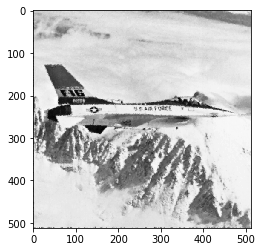

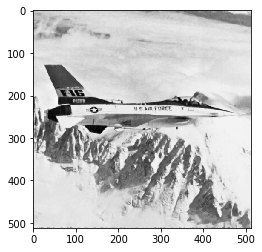

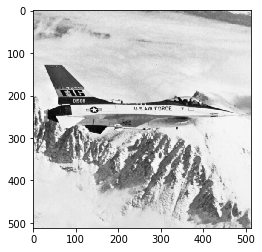

31.57663583755493
27.396990770101546
0.9680522377921683
0.8064206952477813


In [12]:
model = SRCNN("SRCNN_afterGAUSS_0492.h5")
print("== SRCNN 80 ==")
X = X.reshape(-1, 512, 512, 1)
dataY = dataY.reshape(-1, 512, 512, 1)
score = model.evaluate(X, dataY, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

result = model.predict(X)
result = result.reshape(-1, 512, 512)
X = X.reshape(-1, 512, 512)
dataY = dataY.reshape(-1, 512, 512)

img = X[7]
plt.imshow(img, cmap="gray")
plt.show()

img = result[7]
plt.imshow(img, cmap="gray")
plt.show()

img = dataY[7]
plt.imshow(img, cmap="gray")
plt.show()
print(PSNR(dataY[7], result[7]) )

totalPSNR = 0
for i in range(400):
    totalPSNR += PSNR(dataY[i], result[i])
#print(totalPSNR)
print(totalPSNR / 400)

totalSSIM = 0
for i in range(400):
    totalSSIM += SSIM(dataY[i], result[i], 1.0)
print(SSIM(dataY[7], result[7]))
print(totalSSIM / 400)

count = 0
for i in range(80):
    img = result[count]
    img = 255 * img # Now scale by 255
    img = img.astype(np.uint8)
    cv2.imwrite("../../Denoise_80_afterGAUSS/" + str(i+1) + '_denoise50.bmp', img)
    img = result[count+1]
    img = 255 * img # Now scale by 255
    img = img.astype(np.uint8)
    cv2.imwrite("../../Denoise_80_afterGAUSS/" + str(i+1) + '_denoise60.bmp', img)
    img = result[count+2]
    img = 255 * img # Now scale by 255
    img = img.astype(np.uint8)
    cv2.imwrite("../../Denoise_80_afterGAUSS/" + str(i+1) + '_denoise70.bmp', img)
    img = result[count+3]
    img = 255 * img # Now scale by 255
    img = img.astype(np.uint8)
    cv2.imwrite("../../Denoise_80_afterGAUSS/" + str(i+1) + '_denoise80.bmp', img)
    img = result[count+4]
    img = 255 * img # Now scale by 255
    img = img.astype(np.uint8)
    cv2.imwrite("../../Denoise_80_afterGAUSS/" + str(i+1) + '_denoise90.bmp', img)
    count+=5
